# Dynamic Programming

In this exercise we will look at dynamic programming (DP). We will solve the prediction problem (policy evaluation) and use policy improvement to find better policies. We then use policy iteration and value iteration to find the optimal policies.

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

# progress bar, see https://github.com/tqdm/tqdm
import tqdm
import time

import sys

sys.path.append('.')
# Simple Gridworld environment for the exercise
from mdp import RState, MDPGridworld, WalledGridworld, SlipperyGridworld

## Gridworld

While we will write the functions for any MDP, we will use different gridworlds in this exercise. They are defined in the file mdp.py.

The `MDPGridworld`  class implements a gridworld of a given size with walls at each side. If an action is taken into a wall, then the agent remains at the same place. The gridworld uses the `RState` class from the last exercise to implement the states. Most of the algorithms from this exercise work on any MDP, so we will pass the array of states that define the MDP. This can be optained from the gridworld using the property `states`.

### Walled Gridworld

The class `WalledGridworld` extends `MDPGridworld` by adding a method to define interior walls. It replaces all existing transitions between the states on either side of the wall with transitions that remain in the same state. Transistions that are added later are not affected by the walls.

### Slippery Gridworld

Finally, `SlipperyGridworld` adds a method to define a slippery patch that will add a transition to the grid cell to the south (if not on a border) as programmed in the last exercise.

### Env
We will not use a gym.Env as dynamic programming methods allow for sweeps and parallel computation with a model, while envs are for calculation along episodes.



The code below defines and displays a basic gridworld with its state ids. We will use state 11 (3, 2) as starting state and mark it in the display. State 0 is a terminal state.

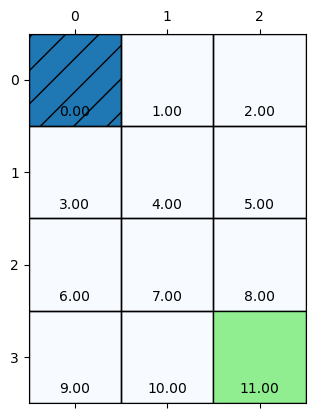

In [5]:
gw = MDPGridworld(height=4, width=3)
gw.state(0,0).is_terminal = True
gw.state(3,2).color = 'lightgreen'

fig, ax = plt.subplots()
gw.render(gw.all_state_ids(), ax)


Besides this gridworld, we will use another one with a wall between states 0 and 3 and slippery patches at states 5 and 7. The location of the slippery patches are shown in light blue.


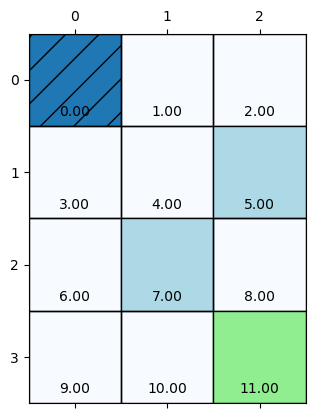

In [6]:
gws = SlipperyGridworld(4, 3)
gws.state(0,0).is_terminal = True
gws.state(3,2).color = 'lightgreen'

gws.add_wall(0,0,1,0)
gws.add_slippery_patch(1,2, 0.4)
gws.add_slippery_patch(2,1, 0.5)

fig, ax = plt.subplots()
gws.render(gws.all_state_ids(), ax)

Some more example operations on the gridworld that will be needed.

In [7]:
assert gws.height == 4
assert gws.width == 3
assert gws.size == 12
assert gws.NR_ACTIONS == 4

# getting a state by its coordinates
state = gws.state(2, 1)

# getting a state by its id (states is a 1D array)
state2 = gws.states[4]

# getting all transitions for a state for action 0
t = state2.transitions[0]
print(t)
print(gws.states[7].transitions[3])

# as it is a slippery patch, there are 2 transitions, get the probability, next state and reward for each
for p, s, r in t:
    print(f"Probability: {p}, next state: {s.state_id}, reward: {r}")

[[1.0, State 1, -1.0]]
[[0.5, State 6, -1.0], (0.5, State 10, -1.0)]
Probability: 1.0, next state: 1, reward: -1.0


## Policy evaluation

First we want to calculate the value function for a given policy, this is called policy evaluation or the *prediction* problem.

In order to write a function for all policies, we must first define a policy. A policy gives the probability of each action in each state, so we can define it as a 2D array of the state id and the action. (as seen in the last exercise)

In [8]:
# create a policy function
p = np.zeros((gw.size, gw.NR_ACTIONS), dtype=float)

# fill it with probability 1/4 for all actions
p.fill(1.0 / gw.NR_ACTIONS)

### One step policy evaluation
Now we want to write a function that performs one step of the policy evaluation. So given a previous estimate for the value function it should calculate a better estimate by using the Bellman equation. In dynamic programming, we can sweep through all the states, so we calculate a new estimate for all the states from the old estimates of the states. Complete the function below.


In [9]:
def predict_value(policy: np.array, states, v_old: np.array, gamma: float) -> np.array:
    """
    Calculate a new estimate of the value function from the old estimate given the policy and the MDP (as array of
    states).
    Args:
        policy: the policy function (2D array with state_id, action)
        gridworld: the gridworld on which to calculate the value function
        v_old: the previous estimate of the value function (1D array with state_id as index)
        gamma: the discount factor for the return
    Returns:
        the new value estimation
    """
    v_new = np.zeros(states.size, dtype=float)
    nr_actions = policy.shape[1]
    for state in states:
        if state.is_terminal:
            #v_new[state.state_id] = 0
            pass
        else:
            # YOUR CODE HERE
            new_v_value = 0
            for i in range (nr_actions):
                transition_array = state.transitions[i]
                for transition in transition_array:
                    
                    probability = transition[0]
                    next_state = transition[1]
                    reward = transition[2]
                    prob_of_action= policy[state.state_id, i]
                    old_v_value = v_old[next_state.state_id]
                    new_v_value += prob_of_action * probability * (reward + (gamma * old_v_value))
            try: 
                v_new [state.state_id] = new_v_value
            except ValueError:
                print(str(type(probability)), str(type(next_state)), str(type(reward)), str(type(prob_of_action)), str(type(old_v_value)), str(type(gamma)), str(type(new_v_value)))
                print(str(gamma))
                
                

    return v_new

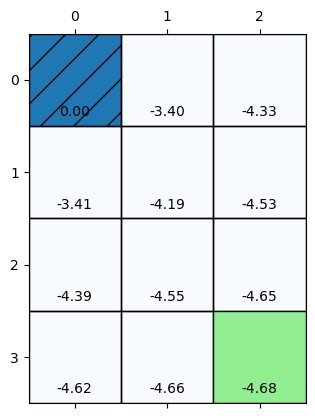

In [10]:
v_init = np.zeros(gw.size, dtype=float)
v_new = predict_value(p, gw.states, v_init, 1.0)
#
assert v_new.sum() == -(gw.size) + 1
assert v_new[0] == 0
assert v_new[4] == -1
assert v_new[10] == -1

# same with different gamma 
v_new_g = predict_value(p, gw.states, v_init, 0.9)
assert (v_new == v_new_g).all()


# apply it multiple times
v_new_g = predict_value(p, gw.states, v_init, 0.9)
for i in range(5):
    v_new_g = predict_value(p, gw.states, v_new_g, 0.9)

fig, ax = plt.subplots()
gw.render(v_new_g, ax)

np.testing.assert_allclose(v_new_g, [ 0., -3.40203391, -4.33078548, -3.40921, -4.19075831, -4.53038562, -4.38606561, -4.55390014, -4.64599334, -4.62255713, -4.65919223, -4.6798235])


### Iterative Policy Evaluation

In order to obtain the real values, we must repeat this operation until the array does not change anymore. Using the function predict_value from above, implement the function predict_value_conv below. It should iterate until the maximal absolute value change for a state is smaller than the given threshold.


In [11]:
def predict_value_conv(policy, states, gamma, threshold):
    """
    Iterative Policy Evaluation for a fixed policy.

    Args:
        policy: a 2D array [num_states x num_actions] with probabilities of each action
        states: a list/array of state objects
                each state has:
                  - state_id: int index
                  - is_terminal: bool
                  - transitions[a] -> list of (prob, next_state, reward)
        gamma: discount factor
        threshold: convergence threshold (max difference allowed between iterations)
    Returns:
        v_new: the converged state-value function as a NumPy array
    """

    
    v_old = np.ones(states.size, dtype=float)
    v_new = np.zeros(states.size, dtype=float)
    
    while np.max(np.abs(v_new - v_old)) > threshold:
        v_old = v_new.copy()
        # Hier nutzen wir predict_value, um die neue Sch√§tzung zu erhalten:
        v_new = predict_value(policy, states, v_old, gamma)
    
    return v_new



In [12]:
v = predict_value_conv(p, gw.states, 1.0, 0.00001)
np.testing.assert_allclose(v, [0., -21.187, -29.714, 
                               -22.812, -29.848, -34.240, 
                               -34.588, -37.152, -39.159, 
                               -39.800, -41.0133, -42.086], atol=0.001)

# same with discount factor
v2 = predict_value_conv(p, gw.states, 0.9, 0.00001)
np.testing.assert_allclose(v2, [0., -5.510, -7.350, 
                           -5.654,-7.183,-8.014,
                           -7.848, -8.304, -8.626,
                            -8.631, -8.805, -8.949],  atol=0.001)

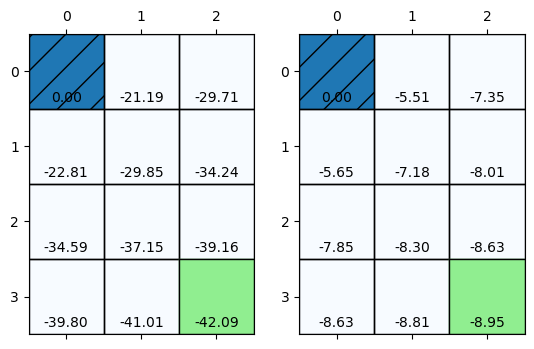

In [13]:
# lets render the two results with gamma 1.0 and 0.9
v = predict_value_conv(p, gw.states, 1.0, 0.00001)
v2 = predict_value_conv(p, gw.states, 0.9, 0.00001)
fig, (ax1, ax2) = plt.subplots(1, 2)
gw.render(v, ax1)
gw.render(v2, ax2)

Lets do the same with the slippery gridworld and plot the results. The grid cells (1, 0) with a wall to (0, 0) now has a much higher value than the cell (0, 1) and all cells have higher values due to the slippery patches.

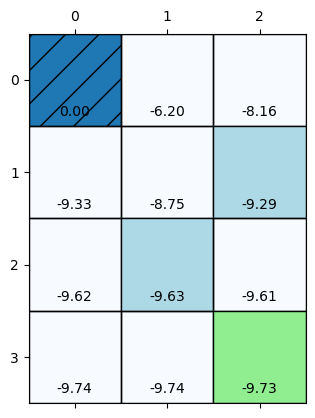

In [14]:
v = predict_value_conv(p, gws.states, 0.9, 0.00001)
fig, ax = plt.subplots()
gws.render(v, ax)

## Policy Improvement

In the next step, we want to find a better policy from v. We can do this by using a greedy policy with respect to v that will assign a probability of 1 by taking the best action, and a probability of 0 for all the other actions.

The greedy policy is the one that maximises the total return from a given state. As we have a state-value function, the return has to be calculated from the reward obtained by the action and the state-value from the next state, and this for all possible outcomes. If the next state is a terminal state, its value function is defined as 0. Complete the implementation below.

Hint: you will have to calculate the expected return for each action in a state and get the action with the maximal value, this could be calculated in an array to which argmax is applied

In [15]:
def greedy_policy_from_v(value: np.array, states, gamma: float, nr_actions: int) -> np.array:
    """
    Calculate a greedy policy from v for the given gridworld.
    Args:
        value: the value function
        states: the states for the MDP
        gamma: the discount factor.
        nr_actions: the number of actions in the MDP
    Returns:
        the greedy policy
    """
    # the policy is defines as a probability function over all actions
    p = np.zeros((states.size, nr_actions), dtype=float)
    # YOUR CODE HERE
    for state in states:
        if state.is_terminal:
            continue
        possible_actions = []
        for action_number in range(nr_actions):
            for transition in state.transitions[action_number]:
                probablity = transition[0]
                next_state = transition[1]
                reward = transition[2]
                
                possible_actions.append(probablity * (reward +gamma * value[next_state.state_id]))
        #chose action
        action_number_greedy = np.argmax(possible_actions)
        for a in range(nr_actions):
            p[state.state_id, a] = 1.0 if action_number_greedy == a else 0.0

    return p

    

In [16]:
v = predict_value_conv(p, gw.states, 0.9, 0.00001)
p_greedy = greedy_policy_from_v(v, gw.states, 0.9, 4)

# must have shape of a policy function
assert p_greedy.shape == (gw.size,4)

# sum of all actions should be 1, there should not be a probability for the terminal state
assert p_greedy.sum() == 11
assert p_greedy[1,0] == 0
assert p_greedy[1,3] == 1



Text(0.5, 1.0, 'West')

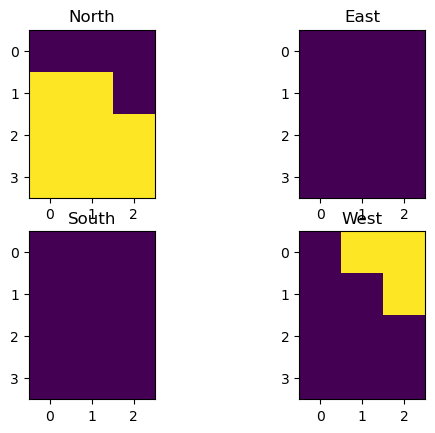

In [17]:
# we can plot the values directly for each action, if the policy is 1 at that position, the value will be 1, otherwise 0

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(p_greedy[:,gw.N].reshape(4,3))
axs[0, 0].set_title('North')
axs[0, 1].imshow(p_greedy[:,gw.E].reshape(4,3))
axs[0, 1].set_title('East')
axs[1, 0].imshow(p_greedy[:,gw.S].reshape(4,3))
axs[1, 0].set_title('South')
axs[1, 1].imshow(p_greedy[:,gw.W].reshape(4,3))
axs[1, 1].set_title('West')

While the plot can display the policy, it is not so straight-forward to see. Let us define a function that can display arrows for the direction with the maximal probability and a plot function that uses it and also displays the values of a gridworld.

In [18]:
def policy_to_direction(p: np.array) -> (np.array, np.array):
    """
    Calculate the direction of the max value of the policy  into two arrays that can be plotted.
    """
    u = np.zeros((p.shape[0]), dtype=float)
    v = np.zeros((p.shape[0]), dtype=float)
    for i in range(p.shape[0]):
        direction = np.argmax(p[i,:])
        if p[i, direction] > 0:
            if direction == MDPGridworld.N:
                u[i] = 0.0
                v[i] = 1.0
            if direction == MDPGridworld.E:
                u[i] = 1.0
                v[i] = 0.0
            if direction == MDPGridworld.S:
                u[i] = 0.0
                v[i] = -1.0
            if direction == MDPGridworld.W:
                u[i] = -1.0
                v[i] = 0.0
    return u,v

def plot_policy_values(p, values, g):
    """
    Plot the policy as arrows, and the values as text using the render function from the gridworld g
    """
    fig, ax = plt.subplots()
    g.render(values, ax)

    u,v = policy_to_direction(p)
    u = u.reshape((g.height, g.width))
    v = v.reshape((g.height, g.width))
    ax.quiver(u, v)
    

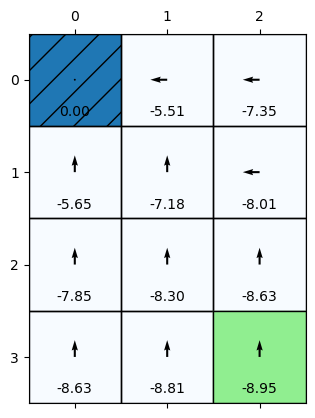

In [19]:
plot_policy_values(p_greedy, v, gw)

## Policy Iteration

Once we have a better policy, we can evaluate it to get a better value function.

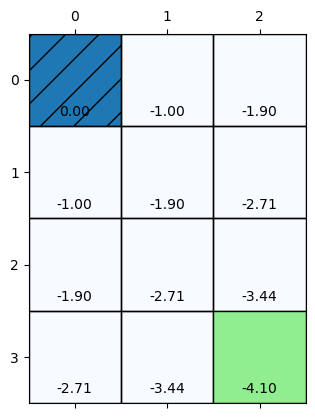

In [20]:
v_better = predict_value_conv(p_greedy, gw.states, 0.9, 0.001)
fig, ax = plt.subplots()
gw.render(v_better, ax)

The policy has changed quite a bit in just one iteration and seems to be optimal already, but by looking at the value function, we see that the policy is not unique. For example going E in the state (2,1) is also possible. Both direction go from a value of -2.71 to -1.9.

Next we can calculate the full policy iteration that alternates between policy evaluation and policy improvement.

In [21]:
def policy_iteration(states: [RState], 
                     nr_actions: int, 
                     gamma: float,
                     threshold: float) -> np.array:
    """
    Calculates the policy iterations for the MDP and return the optimal value function and the optimal policy.

    The iteration is calculated until the policy does not change anymore
    Args:
        states: the states of the MDP
        nr_actions: the (maximal) number of actions for a state in the MDP
        gamma: the discount factor
        threshold: threshold for convergence of the value function
    Returns:
        a tuple (v,p) where v is the optimal value function and p the optimal policy
    """
    v_new = np.zeros(states.size, dtype=float)
    v_old = np.ones(states.size, dtype=float)
    #empty policy init
    policy = np.zeros((gw.size, gw.NR_ACTIONS), dtype=float)
    policy.fill(1.0 / gw.NR_ACTIONS)

    policy_old = np.zeros((gw.size, gw.NR_ACTIONS), dtype=float)

    
    #get updated value function
    while not np.array_equal(policy, policy_old):
        v_new = predict_value_conv(policy, states, gamma, threshold)
        policy_old = policy
        policy = greedy_policy_from_v(v_new, states, gamma, nr_actions)
    
    return (v_new, policy)
            
        
    

In [22]:
# This time, we will test it on the slippery gridworld

value_test, policy_test = policy_iteration(gws.states, gws.NR_ACTIONS, 0.9, 0.0001)

assert value_test.shape[0] == 12
assert policy_test.shape == (12,4)
# grid with direct path to the terminal state
assert value_test[1] == -1.0
assert value_test[2] == -1.90
assert value_test[3] == -2.71
assert value_test[4] == -1.90

# value of the slippery cell
np.testing.assert_allclose(value_test[7], -3.873, atol=0.001)

assert policy_test[1, gw.W] == 1.0
assert policy_test[1, gw.E] == 0.0


Let us plot the result.

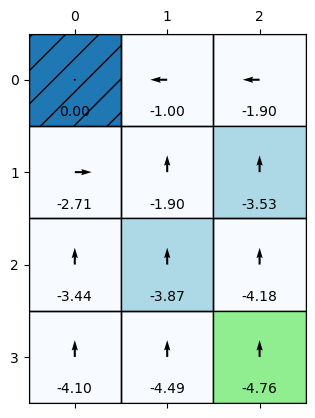

In [23]:
value, policy = policy_iteration(gws.states, gws.NR_ACTIONS, 0.9, 0.0001)
plot_policy_values(policy, value, gws)


## Value Iteration

A big draw back of the above implementation of policy iteration, is that we have to iterate until convergence of the policy evaluation. However, as discussed in the lecture,  it is not actually necessary to wait for the convergence, we can also to less sweeps. A special case is doing just one sweep, this is called *value iteration*. This is shown in equation 4.10 in the book and in the algorithm on page 83 or in the slides.

Implement this algorithm. This time, do not use any of the previously implemented functions. It is not necessary to compute an explicit policy in the algorithm, just the value function update. So the function will also just return the optimal value function from which a policy can be calculated.

In [33]:
def value_iteration(states: [RState], nr_actions: int, gamma: float, threshold: float, max_iterations: int) -> np.array:
    """
    Calculate the optimal value function for a MDP and return it
    Args:
        states: the states of the MDP
        nr_actions: the (maximal) number of actions for a state in the MDP
        gamma: the discount factor
        threshold: threshold for convergence of the value function
        max_iterations: maximal number of iterations
    Returns:
        the optimal value function for the MDP.
    """
    # YOUR CODE HERE
    v_old = np.ones(states.size, dtype=float)
    v_new = np.zeros(states.size, dtype=float)
    iteration_counter = 0
    
    while iteration_counter < max_iterations and np.max(np.abs(v_new - v_old)) > threshold:
        v_old = v_new.copy()  # Make sure to copy the array
        for state in states:
            if state.is_terminal:
                # Usually terminal state values are set to 0.
                v_new[state.state_id] = 0.0
            else:
                # Compute the value for each action and take the max
                action_values = []
                for a in range(nr_actions):
                    action_value = 0.0
                    transition_array = state.transitions[a]
                    for transition in transition_array:
                        probability = transition[0]
                        next_state = transition[1]
                        reward = transition[2]
                        action_value += probability * (reward + gamma * v_old[next_state.state_id])
                    action_values.append(action_value)
                # Take the maximum action value for the update
                v_new[state.state_id] = max(action_values)
        iteration_counter += 1
        
    return v_new

                    

In [34]:
# we will test the implementation on the gridworld as above, it should get the same results
value_test = value_iteration(gws.states, 4, 0.9, 0.001, 1000)
assert value_test.shape[0] == 12
assert policy_test.shape == (12,4)
# grid with direct path to the terminal state
assert value_test[1] == -1.0
assert value_test[2] == -1.90
assert value_test[3] == -2.71
assert value_test[4] == -1.90

# value of the slippery cell
np.testing.assert_allclose(value_test[7], -3.873, atol=0.001)

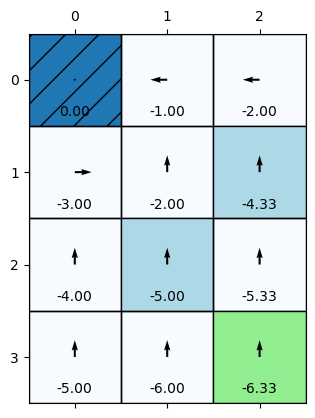

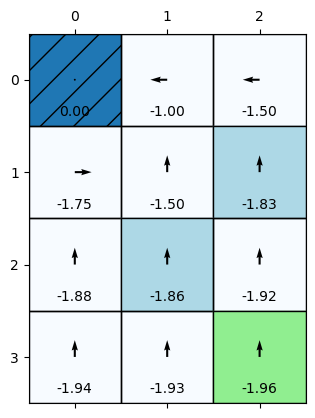

In [35]:
# does the optimal policy depend on the gamma factor?
v1 = value_iteration(gws.states, 4, 1.0, 0.001, 1000)
p1 = greedy_policy_from_v(v1, gws.states, 0.9, 4)
plot_policy_values(p1, v1, gws)

v2 = value_iteration(gws.states, 4, 0.5, 0.001, 1000)
p2 = greedy_policy_from_v(v1, gws.states, 0.5, 4)
plot_policy_values(p2, v2, gws)

Not in this example, but it possible that different gamma factors result in different optimal policies.

End of exercise